# Simulation and inference of Poisson RGG

$$P(G|D, \theta) = \prod_{i<j} \frac{(\mathcal{F}(D_{ij}, \theta))^{A_{ij}}}{A_{ij}!} \exp(-\mathcal{F}(D_{ij}, \theta))$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../utils')

In [109]:
from graphs import get_independent_components_rgg, make_inter_vertex_distances, poissonian_random_geometric_graph
from plot import plot_multigraph
from networkx.linalg.graphmatrix import adjacency_matrix
import pymc3 as pm
import theano
import theano.tensor as tt

In [33]:
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import math

In [5]:
SEED = 42

In [20]:
n = 10
dim = 2

In [89]:
kr_exp = 2
k0_exp = 1
exponential_kernel = lambda dist: k0_exp*math.exp(-kr_exp * dist)

In [71]:
r = np.random.RandomState(SEED)
G_poisson = poissonian_random_geometric_graph(n, 1000, r, p_dist=exponential_kernel)

In [72]:
nodes_pos = G_poisson.nodes(data="pos")

In [73]:
adj = adjacency_matrix(G_poisson)
adj = adj.toarray()

In [74]:
adj

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 4, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 4, 0, 0, 0, 0, 0, 1],
       [0, 3, 0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 0]])

In [75]:
assert np.allclose(adj, adj.T)

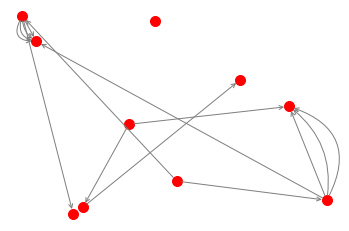

In [77]:
ax = plot_multigraph(G_poisson)

In [84]:
distances = make_inter_vertex_distances(G_poisson)

100%|██████████| 10/10 [00:00<00:00, 11644.38it/s]


In [87]:
distances_filter,  adj_filter = get_independent_components_rgg(G_poisson, distances)

## Inference

In [93]:
distances_exp_tt = theano.shared(distances_filter)

with pm.Model() as model_exp:
    kr = pm.Uniform('kr', 0, 100)
    k0 = pm.Uniform('k0', 0, 100)
    exponential = k0*pm.math.exp(-kr * distances_exp_tt)
    pm.Poisson('obs', mu=exponential, observed=adj_filter)

In [94]:
map_estimate_exp = pm.find_MAP(model=model_exp)

/home/juvid/miniconda3/envs/kolgraph/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -43.055, ||grad|| = 3.0368: 100%|██████████| 19/19 [00:00<00:00, 2680.34it/s]  


In [95]:
with model_exp:
    # fit the model
    trace_exp = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k0, kr]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 3657.94draws/s]
The acceptance probability does not match the target. It is 0.8964408958154049, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 0, 'Samples')

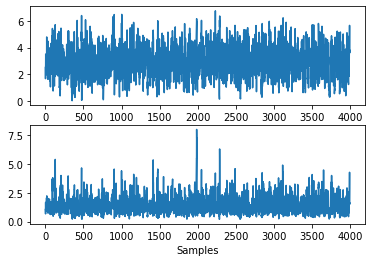

In [96]:
fig, axs = plt.subplots(nrows=2)

ax = axs[0]
ax.plot(range(len(trace_exp['kr'])), trace_exp['kr'])
ax.set_xlabel('Iterations')
ax.set_xlabel('Samples')

ax = axs[1]
ax.plot(range(len(trace_exp['k0'])), trace_exp['k0'])
ax.set_xlabel('Iterations')
ax.set_xlabel('Samples')

Text(0, 0.5, 'Density')

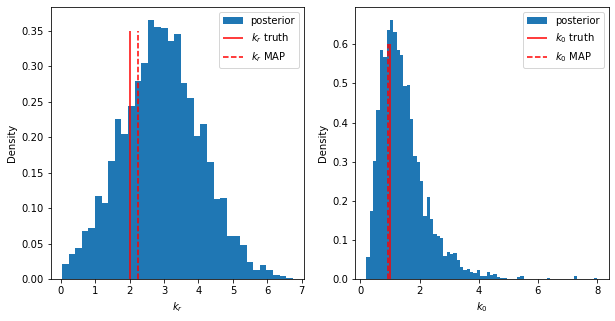

In [105]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax = axs[0]
ymax = 0.35
ax.hist(trace_exp['kr'], label='posterior', bins='auto', density=True)
ax.vlines(kr_exp, 0, ymax, color='red', label='$k_r$ truth')
ax.vlines(map_estimate_exp['kr'], 0, ymax, color='red', linestyle='--', label='$k_r$ MAP')
ax.legend();
ax.set_xlabel('$k_r$')
ax.set_ylabel('Density')

ax = axs[1]
ymax = 0.6
ax.hist(trace_exp['k0'], label='posterior', bins='auto', density=True)
ax.vlines(k0_exp, 0, ymax, color='red', label='$k_0$ truth')
ax.vlines(map_estimate_exp['k0'], 0, ymax, color='red', linestyle='--', label='$k_0$ MAP')
ax.legend();
ax.set_xlabel('$k_0$')
ax.set_ylabel('Density')

# Custom likelihood

In [106]:
def log_like_poisson_rgg(y, D, kr, k0):
    F_D = k0*tt.exp(-kr * D)
    return tt.sum(y*tt.log(F_D) - F_D)

In [110]:
with pm.Model() as model_exp_custom_ll:
    kr_custom_ll = pm.Uniform('kr', 0, 100)
    k0_custom_ll = pm.Uniform('k0', 0, 100)
    ll = pm.DensityDist('ll', log_like_poisson_rgg, 
                        observed=dict(y=adj_filter, D=distances_filter, 
                                      kr=kr_custom_ll, k0=k0_custom_ll,
                                     )
                       )

In [111]:
map_estimate_exp_custom_ll = pm.find_MAP(model=model_exp_custom_ll)

/home/juvid/miniconda3/envs/kolgraph/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -38.085, ||grad|| = 3.0368: 100%|██████████| 19/19 [00:00<00:00, 3289.24it/s]  


In [112]:
with model_exp_custom_ll:
    trace_exp_custom_ll = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [k0, kr]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4185.98draws/s]
The acceptance probability does not match the target. It is 0.8905696978838485, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Text(0, 0.5, 'Density')

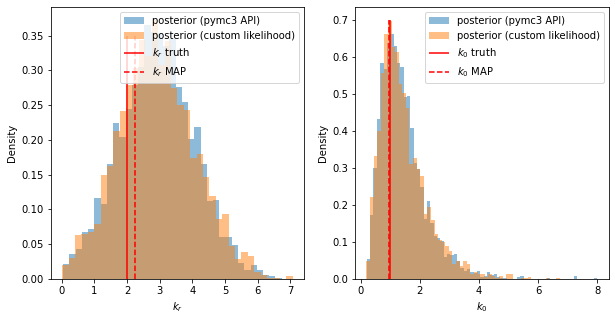

In [116]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

ax = axs[0]
ymax = 0.35
ax.hist(trace_exp['kr'], bins='auto', density=True, label='posterior (pymc3 API)', alpha=0.5)
ax.hist(trace_exp_custom_ll['kr'], bins='auto', density=True, label='posterior (custom likelihood)', alpha=0.5)
ax.vlines(kr_exp, 0, ymax, color='red', label='$k_r$ truth')
ax.vlines(map_estimate_exp['kr'], 0, ymax, color='red', linestyle='--', label='$k_r$ MAP')
ax.legend();
ax.set_xlabel('$k_r$')
ax.set_ylabel('Density')

ax = axs[1]
ymax = 0.7
ax.hist(trace_exp['k0'], bins='auto', density=True, label='posterior (pymc3 API)', alpha=0.5)
ax.hist(trace_exp_custom_ll['k0'], bins='auto', density=True, label='posterior (custom likelihood)', alpha=0.5)
ax.vlines(k0_exp, 0, ymax, color='red', label='$k_0$ truth')
ax.vlines(map_estimate_exp['k0'], 0, ymax, color='red', linestyle='--', label='$k_0$ MAP')
ax.legend();
ax.set_xlabel('$k_0$')
ax.set_ylabel('Density')